# Homework 3 - Credit Analytics
Submission by Dennis Goldenberg

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime as dt

## $\underline{\text{Question 1}}$

### a. Examining volatility and correlation structure of yield curves
I read the yield curve in and generate the daily percent change Matrix:

In [2]:
ticker = ['DGS1MO',  'DGS3MO', 'DGS6MO','DGS1','DGS2',
           'DGS3', 'DGS5','DGS7', 'DGS10','DGS20','DGS30']
sdt = dt.datetime(2003, 4, 10)
edt = dt.datetime(2024, 4, 12)
source = 'fred'
yieldcurve = pd.DataFrame(web.DataReader(ticker, source, sdt, edt))
yieldcurve = yieldcurve.dropna()
pctChange = yieldcurve.pct_change().dropna()
pctChange

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2003-04-11,0.000000,0.026316,0.025862,0.040000,0.031250,0.029557,0.020761,0.008671,0.012658,0.004049,0.003868
2003-04-14,0.008475,0.025641,0.025210,0.023077,0.054545,0.038278,0.023729,0.017192,0.010000,0.006048,0.001927
2003-04-15,-0.016807,-0.016667,-0.008197,-0.007519,-0.028736,-0.023041,-0.019868,-0.016901,-0.014851,-0.012024,-0.001923
2003-04-16,-0.017094,-0.008475,-0.008264,-0.007576,-0.011834,-0.009434,-0.003378,-0.002865,-0.005025,-0.002028,-0.011561
2003-04-17,-0.008696,0.008547,0.000000,0.022901,0.023952,0.023810,0.013559,0.005747,0.005051,-0.002033,-0.001949
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08,0.001828,0.000000,0.001873,0.003960,0.010571,0.013216,0.011416,0.009112,0.006834,0.000000,0.002203
2024-04-09,0.000000,0.000000,-0.001869,-0.007890,-0.008368,-0.017391,-0.013544,-0.011287,-0.013575,-0.010753,-0.010989
2024-04-10,0.001825,0.003683,0.011236,0.031809,0.048523,0.055310,0.054920,0.047945,0.043578,0.034783,0.031111


One slight issue is that, for maturities of 1 and 3 months, there are cases where the yield is 0, meaning the next day's percentage change would be infinity. I generate the percent change matrix with these rows excluded to get sensible results:

In [3]:
mask1MO = ((pctChange["DGS1MO"] > 5000000) | (pctChange["DGS1MO"] < -5000000)).values
mask3MO = ((pctChange["DGS3MO"] > 5000000) | (pctChange["DGS3MO"] < -5000000)).values
mask = mask1MO | mask3MO
pCNoInf = pctChange[~(mask)]

I examine both the means and standard deviations of the percent changes of the individual maturities, as well as the entire variance-covariance matrix:

In [4]:
meansSD = np.vstack([pCNoInf.mean(), pCNoInf.std()])
meanSDChange = pd.DataFrame(meansSD.T, index = pCNoInf.columns,
                            columns = ["Average % change","Standard Deviation"])
meanSDChange

,Average % change,Standard Deviation
DGS1MO,0.026158,0.340872
DGS3MO,0.017462,0.257891
DGS6MO,0.004202,0.106679
DGS1,0.001606,0.052359
DGS2,0.001430,0.049132
DGS3,0.001128,0.043144
DGS5,0.000772,0.035398
DGS7,0.000531,0.029100
DGS10,0.000404,0.025359
DGS20,0.000229,0.019901


In [5]:
pCNoInf.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.286878,0.193646,0.145987,0.046646,0.045687,0.026228,0.019494,0.016355,0.022283,0.022453
DGS3MO,0.286878,1.000000,0.354084,0.186802,0.097015,0.083245,0.066044,0.056486,0.054324,0.050522,0.052292
DGS6MO,0.193646,0.354084,1.000000,0.285864,0.145925,0.141137,0.124743,0.109274,0.116982,0.120393,0.121919
DGS1,0.145987,0.186802,0.285864,1.000000,0.457498,0.451116,0.407459,0.385460,0.354379,0.320490,0.306785
DGS2,0.046646,0.097015,0.145925,0.457498,1.000000,0.807512,0.761878,0.701889,0.630252,0.547696,0.507569
DGS3,0.045687,0.083245,0.141137,0.451116,0.807512,1.000000,0.914180,0.859412,0.790411,0.704861,0.656183
DGS5,0.026228,0.066044,0.124743,0.407459,0.761878,0.914180,1.000000,0.959265,0.906666,0.828138,0.781184
DGS7,0.019494,0.056486,0.109274,0.385460,0.701889,0.859412,0.959265,1.000000,0.962750,0.903309,0.864201
DGS10,0.016355,0.054324,0.116982,0.354379,0.630252,0.790411,0.906666,0.962750,1.000000,0.957605,0.929271
DGS20,0.022283,0.050522,0.120393,0.320490,0.547696,0.704861,0.828138,0.903309,0.957605,1.000000,0.972052


I make 3 observations from these two results:
- The average percent change and standard deviation of percent change is $\textbf{higher}$ for shorter maturities, and $\textbf{lower}$ for longer maturities. This suggests that treasury rates with shorter maturities are more volatile than treasuries with longer maturities.
- All entries in the correlation matrix are positive. This suggests that there is a common market factor moving yields of all maturities in one direction or the other.
- For any given maturity length, the change in yield of that maturity length is generally more correlated with changes in yields of similar maturity lengths. For example, change in yield of Treasury securities with a maturity of 30 years is most correlated with the change in securities with maturities of 10 and 20 years.

### b. Estimating $\alpha, \beta, \sigma$ in simple short rate model

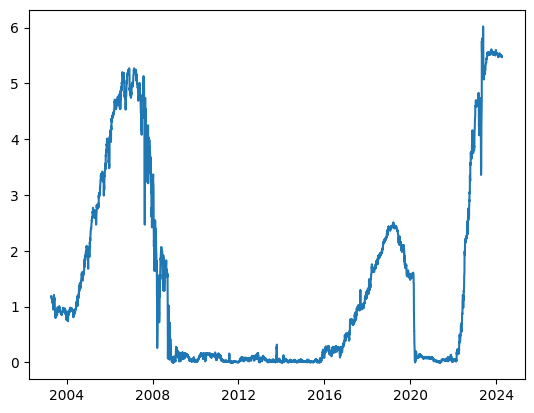

In [9]:
plt.plot(yieldcurve["DGS1MO"])
plt.show()

### c. Calculating spread between points with one month yield

### d. Monte Carlo Simulation Engine
Read "Some tricks on Monte Carlo Simulation"

### e. Pricing Interest Rate Swap

### f. Potential future exposure